# CESM-LE drivers of phyto change

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint100m','spC_zint100m','zooC_zint100m',
             'spNPP_zint100m','diatNPP_zint100m','NPP_zint100m','zoo_prod_zint100m',
             'TEMP_100m_mean','SHF_QSW','Fe_avg_100m','phys_med_Fe','NO3_100m_mean','PAR_avg_100m']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
NO3_100m_mean
PAR_avg_100m
CPU times: user 848 ms, sys: 70.7 ms, total: 919 ms
Wall time: 1.75 s


### calculate PAR and Fix units

In [3]:
ds['PAR_surf'] = ds['SHF_QSW'] * 0.45

In [4]:
ds['mesozooC'] = ds.zooC_zint100m * (ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m))
ds['diat_frac'] = ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m)

ds['mesozooC_prod'] = ds.zoo_prod_zint100m * (ds.diatC_zint100m/(ds.diatC_zint100m + ds.spC_zint100m))
ds['diat_frac_NPP'] = ds.diatNPP_zint100m/(ds.diatNPP_zint100m + ds.spNPP_zint100m)

ds['phytoC_zint'] = ds.spC_zint100m + ds.diatC_zint100m

In [5]:
convert = 0.01 * 86400. * 1000. *1000. #converting from mmol/m3 cm/s to nmol/m2/d
ds['phys_med_Fe'] = ds.phys_med_Fe * convert
ds.phys_med_Fe.attrs['units'] = 'nmol/m^2/d'

### convert production from mmol/m3 cm/sec to gC/m2/y
ds['zoo_prod_zint100m'] = ds.zoo_prod_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.zoo_prod_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['mesozooC_prod'] = ds.mesozooC_prod * 0.01 * 86400. * 365. * 0.001 * 12.
ds.mesozooC_prod.attrs['units'] = 'gC m-2 y-1'

ds['NPP_zint100m'] = ds.NPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.NPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['diatNPP_zint100m'] = ds.diatNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.diatNPP_zint100m.attrs['units'] = 'gC m-2 y-1'

ds['spNPP_zint100m'] = ds.spNPP_zint100m * 0.01 * 86400. * 365. * 0.001 * 12.
ds.spNPP_zint100m.attrs['units'] = 'gC m-2 y-1'


### get pop grid

In [6]:
grid = pop_tools.get_grid('POP_gx1v6')

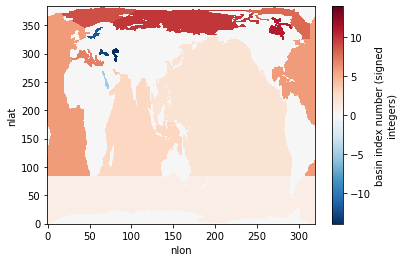

In [7]:
grid.REGION_MASK.plot()

In [8]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA

### mask out nans in ds

In [9]:
ds = ds.where(grid.REGION_MASK>0)

### Calculate TL3 productivity

In [10]:
## create Ft grid
Ft = np.full((34, 181, 384, 320), 1, dtype=float)
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id',
              'dim_1':'time',
              'dim_2':'nlat',
              'dim_3':'nlon'})

Ft_cold = Ft.where(ds.TEMP_100m_mean < 20.)
Ft_warm =  Ft.where(ds.TEMP_100m_mean >= 20.) * 0.74

#now convert everything to numpy arrays so we can merge the two grids
Ft = np.asarray(Ft)
Ft_cold = np.asarray(Ft_cold)
Ft_warm = np.asarray(Ft_warm)

Ft[~np.isnan(Ft_cold)] = Ft_cold[~np.isnan(Ft_cold)]
Ft[~np.isnan(Ft_warm)] = Ft_warm[~np.isnan(Ft_warm)]

#now put it back to an xarray
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id',
              'dim_1':'time',
              'dim_2':'nlat',
              'dim_3':'nlon'})

### mask out land
Ft = Ft.where(grid.REGION_MASK>0)

Ft['time'] = ds.time
Ft['member_id'] = ds.member_id

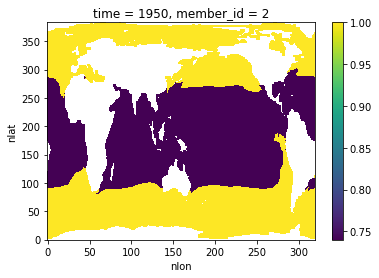

In [11]:
Ft.isel(member_id=1,time=30).plot()

In [12]:
#trophic level 3
L = 3
alpha = 1 #0.14 alpha is harvest efficieny via fishing, changed to one since we aren't "catching" TL3
E = 0.14

ds['TL3_prod'] = alpha * ds['mesozooC_prod'] * (Ft * E)**(L-2.1) #answer will be in gC/m2/y
ds.TL3_prod.attrs = ds.zoo_prod_zint100m.attrs
ds.TL3_prod.attrs['long_name'] = 'trophic level 3 production'


### ... and TL 4

In [13]:
#trophic level 4
L = 4
alpha = 1 #0.14 alpha is harvest efficieny via fishing, changed to one since we aren't "catching" TL3
E = 0.14

ds['TL4_prod'] = alpha * ds['mesozooC_prod'] * (Ft * E)**(L-2.1) #answer will be in gC/m2/y
ds.TL4_prod.attrs = ds.zoo_prod_zint100m.attrs
ds.TL4_prod.attrs['long_name'] = 'trophic level 4 production'


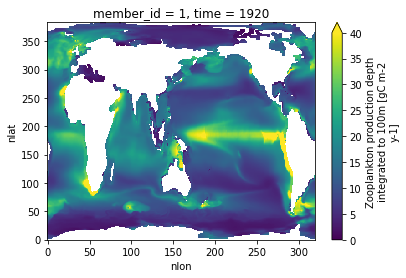

In [14]:
ds.mesozooC_prod.isel(member_id=0,time=0).plot(vmin=0,vmax=40)

In [15]:
ds.NPP_zint100m

<xarray.DataArray 'NPP_zint100m' (time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<where, shape=(181, 34, 384, 320), dtype=float64, chunksize=(181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     NPP depth integrated from 100m
    units:         gC m-2 y-1
    grid_loc:      3114
    cell_methods:  time: mean

In [16]:
# L = 4
# E = 0.14
# ds['TE4'] = ((ds.mesozooC_prod * E**(L-2.1))/ds.NPP_zint100m)**(1/3)

In [17]:
# L = 3
# E = 0.14
# ds['TE3'] = ((ds.mesozooC_prod * E**(L-2.1))/ds.NPP_zint100m)**(1/2)

In [18]:
ds['ETE_to_TL3'] = ds['TL3_prod']/ds['NPP_zint100m']
ds['ETE_to_TL4'] = ds['TL4_prod']/ds['NPP_zint100m']

### extract 1920s

In [19]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [20]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 2090s

In [21]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [22]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

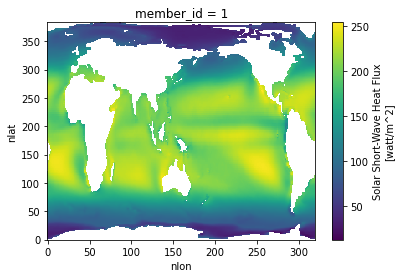

In [23]:
ds_2090s.SHF_QSW.isel(member_id=0).plot()

### calculate ensemble means

In [24]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

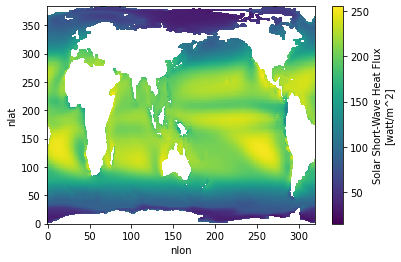

In [25]:
ensemble_mean_2090s.SHF_QSW.plot()

In [26]:
ensemble_mean_1920s #.plot(vmin=0,vmax=5)

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon, z_t
Data variables:
    KMT                (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                 (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    diatC_zint100m     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    spC_zint100m       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    zooC_zint100m      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    spNPP_zint100m     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    diatNPP_zint100m   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    NPP_zint100m       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    zoo_prod_zint100m  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TEMP_100m_mean     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    SHF_QSW            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Fe_avg_100m        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    phys_med_Fe        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    NO3_100m_mean      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    PAR_avg_100m       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    PAR_surf           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    mesozooC           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    diat_frac          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    mesozooC_prod      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    diat_frac_NPP      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    phytoC_zint        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TL3_prod           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TL4_prod           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ETE_to_TL3         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ETE_to_TL4         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>

### ACC and SIZ maskNPP_zint100m

In [27]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1920s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

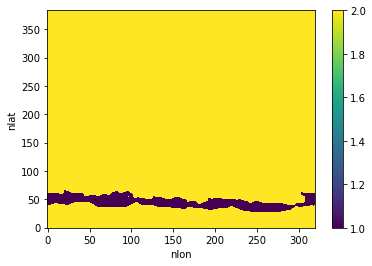

In [28]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC.plot()

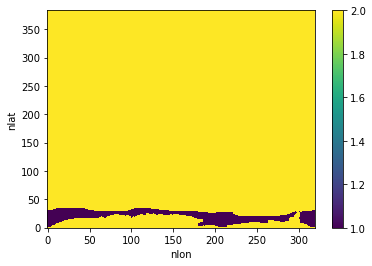

In [29]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ.plot()

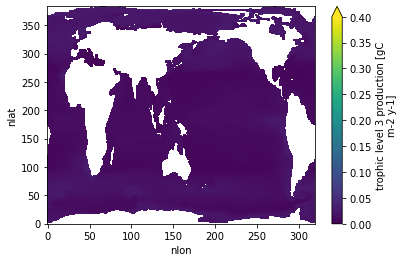

In [30]:
ensemble_mean_1920s.ETE_to_TL3.plot(vmin=0,vmax=0.4)

### MAPS

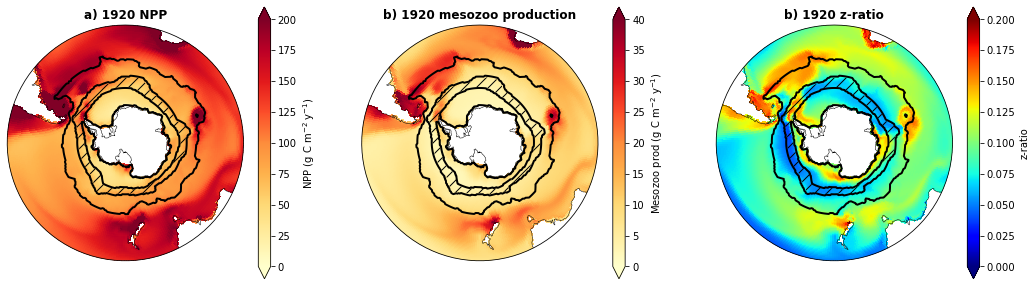

In [86]:
fig = plt.figure(figsize=(18,5))
####################################################################
#  NPP 1920s
####################################################################

cpt='YlOrRd'

##################################### NPP ############################
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) 1920 NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.NPP_zint100m)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=200, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='NPP (g C m$^{-2}$ y$^{-1}$)')



##################################### mesozooprod ############################
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 1920 mesozoo production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.mesozooC_prod)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=40, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mesozoo prod (g C m$^{-2}$ y$^{-1}$)')

##################################### z-ratio ############################
ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 1920 z-ratio',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_1920s.mesozooC_prod/ensemble_mean_1920s.NPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=0.2, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='z-ratio')


### Plot TL3 and TL4 productivity at 1920

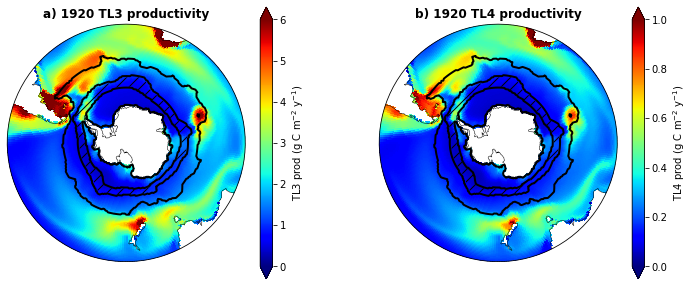

In [103]:
fig = plt.figure(figsize=(12,5))
####################################################################
#  TL3 & 4 1920s
####################################################################

cpt='jet'

##################################### TL3 ############################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) 1920 TL3 productivity',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.TL3_prod)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=6, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both', label= 'TL3 prod (g C m$^{-2}$ y$^{-1}$)')



############################# TL4 ##################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 1920 TL4 productivity',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.TL4_prod)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=1, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both', label= 'TL4 prod (g C m$^{-2}$ y$^{-1}$)')

fig.subplots_adjust(wspace=0.25)
#fig.savefig('/glade/work/kristenk/figs/fig_zoomaps.png', bbox_inches='tight', dpi=300, format='png');

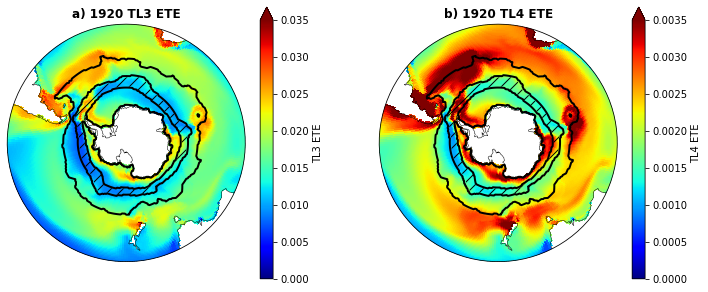

In [91]:
fig = plt.figure(figsize=(12,5))
####################################################################
#  TL3 & 4 1920s
####################################################################

cpt='jet'

##################################### TL3 ############################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) 1920 TL3 ETE',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.TL3_prod/ensemble_mean_1920s.NPP_zint100m)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=0.035, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='TL3 ETE')



############################# TL4 ##################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) 1920 TL4 ETE',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.TL4_prod/ensemble_mean_1920s.NPP_zint100m)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=0.0035, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='TL4 ETE')


fig.subplots_adjust(wspace=0.25)
#fig.savefig('/glade/work/kristenk/figs/fig_zoomaps.png', bbox_inches='tight', dpi=300, format='png');

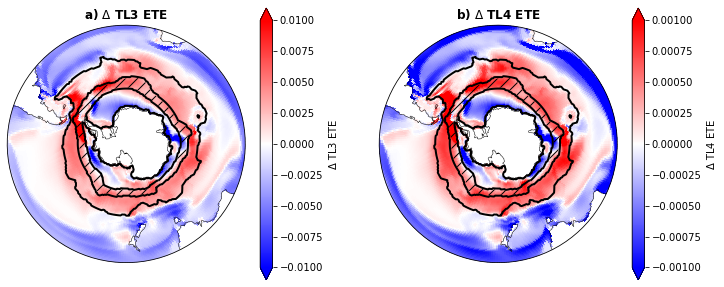

In [95]:
fig = plt.figure(figsize=(12,5))
####################################################################
#  TL3 & 4 1920s
####################################################################

cpt='bwr'

##################################### TL3 ############################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ TL3 ETE',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

diff = (ensemble_mean_2090s.TL3_prod/ensemble_mean_2090s.NPP_zint100m) - (ensemble_mean_1920s.TL3_prod/ensemble_mean_1920s.NPP_zint100m) 

lon, lat, field = utils.adjust_pop_grid(lons, lats, diff )
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.01, vmax=0.01, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL3 ETE')



############################# TL4 ##################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ TL4 ETE',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

diff = (ensemble_mean_2090s.TL4_prod/ensemble_mean_2090s.NPP_zint100m) - (ensemble_mean_1920s.TL4_prod/ensemble_mean_1920s.NPP_zint100m) 

lon, lat, field = utils.adjust_pop_grid(lons, lats, diff)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.001, vmax=0.001, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL4 ETE')


fig.subplots_adjust(wspace=0.25)
#fig.savefig('/glade/work/kristenk/figs/fig_zoomaps.png', bbox_inches='tight', dpi=300, format='png');

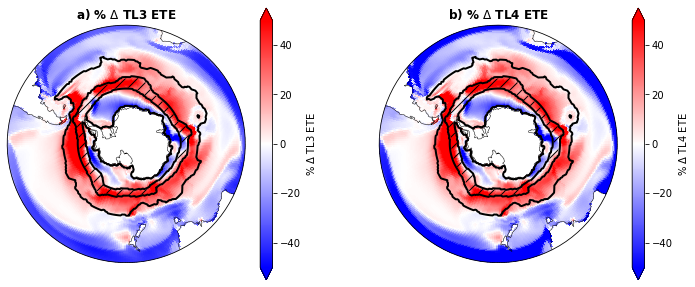

In [ ]:
fig = plt.figure(figsize=(12,5))
####################################################################
#  TL3 & 4 1920s
####################################################################

cpt='bwr'

##################################### TL3 ############################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) % ${\Delta}$ TL3 ETE',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

diff = (ensemble_mean_2090s.TL3_prod/ensemble_mean_2090s.NPP_zint100m) - (ensemble_mean_1920s.TL3_prod/ensemble_mean_1920s.NPP_zint100m) 
per_change3 = 100 * diff/(ensemble_mean_1920s.TL3_prod/ensemble_mean_1920s.NPP_zint100m) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, per_change3 )
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-50, vmax=50, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='% ${\Delta}$ TL3 ETE')



############################# TL4 ##################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) % ${\Delta}$ TL4 ETE',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

diff = (ensemble_mean_2090s.TL4_prod/ensemble_mean_2090s.NPP_zint100m) - (ensemble_mean_1920s.TL4_prod/ensemble_mean_1920s.NPP_zint100m) 
per_change4 = 100 * diff/(ensemble_mean_1920s.TL4_prod/ensemble_mean_1920s.NPP_zint100m) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, per_change4)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-50, vmax=50, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='% ${\Delta}$ TL4 ETE')


fig.subplots_adjust(wspace=0.25)
#fig.savefig('/glade/work/kristenk/figs/fig_zoomaps.png', bbox_inches='tight', dpi=300, format='png');

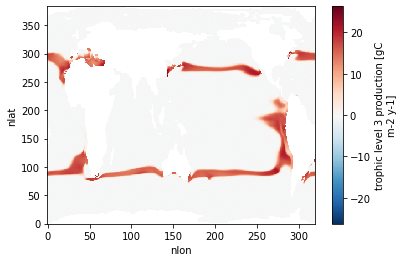

In [101]:
(per_change3 - per_change4).plot()

### Make new figure 5 that has change in zooC, change in mesozooC, ETE to TL3 1920, change in ETE 

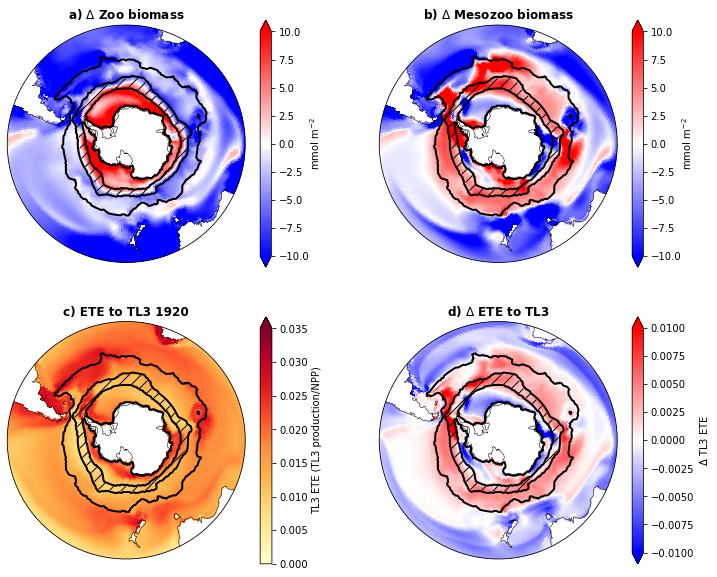

In [31]:
fig = plt.figure(figsize=(12,10))
####################################################################
#  change in zoo biomass
####################################################################



##################################### zoo biomass ############################
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Zoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zooC_zint100m- ensemble_mean_1920s.zooC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Zoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10, labelpad=-1)


############################# large zoo biomass ##################################
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Mesozoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC- ensemble_mean_1920s.mesozooC))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Mesozoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10, labelpad=-1)


##################################### ETE to TL3 1920 ############################


ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ETE to TL3 1920',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_1920s.ETE_to_TL3 )
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=0.035, 
                 cmap='YlOrRd',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='TL3 ETE (TL3 production/NPP)')



############################# delta ETE to TL3 ##################################
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) ${\Delta}$ ETE to TL3',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

diff = ensemble_mean_2090s.ETE_to_TL3 - ensemble_mean_1920s.ETE_to_TL3

lon, lat, field = utils.adjust_pop_grid(lons, lats, diff)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.01, vmax=0.01, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL3 ETE')


fig.subplots_adjust(wspace=0.25)
fig.savefig('/glade/work/kristenk/figs/fig5_zoo_ete_maps.png', bbox_inches='tight', dpi=300, format='png');

### plot global z-ratio for the SI

In [37]:
file='/glade/work/kristenk/z-ratio/z_ratio_POPgrid.nc'
ds_zratio=xr.open_dataset(file,decode_times=False,decode_coords=False)

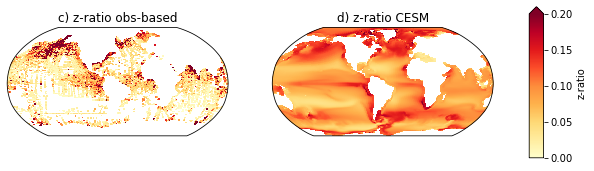

In [63]:
fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) z-ratio obs-based', fontsize=12)
tmp = ds_zratio.z_ratio
lon, lat, field = utils.adjust_pop_grid(lons, lats, tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) z-ratio CESM', fontsize=12)
tmp = ensemble_mean_1920s.mesozooC_prod/ensemble_mean_1920s.NPP_zint100m
lon, lat, field = utils.adjust_pop_grid(lons, lats, tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='YlOrRd',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='z-ratio')

fig.savefig('/glade/work/kristenk/figs/z-ratio_compare.png', bbox_inches='tight', dpi=300, format='png');

In [43]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

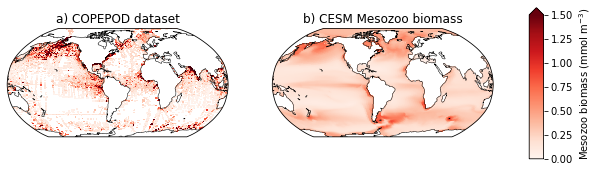

In [64]:
fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) COPEPOD dataset', fontsize=12)
tmp = ds_copepod.copepod_C
lon, lat, field = utils.adjust_pop_grid(lons, lats, tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=1.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) CESM Mesozoo biomass', fontsize=12)
tmp = ensemble_mean_1920s.mesozooC/100.
lon, lat, field = utils.adjust_pop_grid(lons, lats, tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=1.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Mesozoo biomass (mmol m$^{-3}$)')

fig.savefig('/glade/work/kristenk/figs/copepod_compare.png', bbox_inches='tight', dpi=300, format='png');

### convert production terms to mmol/m2/d (from gCm2/y)

In [54]:
convert = 1./12. * 1000. * 1./365.

In [55]:
ensemble_mean_1920s['zoo_prod_zint100m'] = ensemble_mean_1920s['zoo_prod_zint100m'] * convert
ensemble_mean_1920s['mesozooC_prod'] = ensemble_mean_1920s['mesozooC_prod'] * convert
ensemble_mean_1920s['NPP_zint100m'] = ensemble_mean_1920s['NPP_zint100m'] * convert
ensemble_mean_1920s['diatNPP_zint100m'] = ensemble_mean_1920s['diatNPP_zint100m'] * convert
ensemble_mean_1920s['spNPP_zint100m'] = ensemble_mean_1920s['spNPP_zint100m'] * convert
ensemble_mean_1920s['TL3_prod'] = ensemble_mean_1920s['TL3_prod'] * convert

In [56]:
ensemble_mean_2090s['zoo_prod_zint100m'] = ensemble_mean_2090s['zoo_prod_zint100m'] * convert
ensemble_mean_2090s['mesozooC_prod'] = ensemble_mean_2090s['mesozooC_prod'] * convert
ensemble_mean_2090s['NPP_zint100m'] = ensemble_mean_2090s['NPP_zint100m'] * convert
ensemble_mean_2090s['diatNPP_zint100m'] = ensemble_mean_2090s['diatNPP_zint100m'] * convert
ensemble_mean_2090s['spNPP_zint100m'] = ensemble_mean_2090s['spNPP_zint100m'] * convert
ensemble_mean_2090s['TL3_prod'] = ensemble_mean_2090s['TL3_prod'] * convert

### make each set of maps separately

bottom up drivers

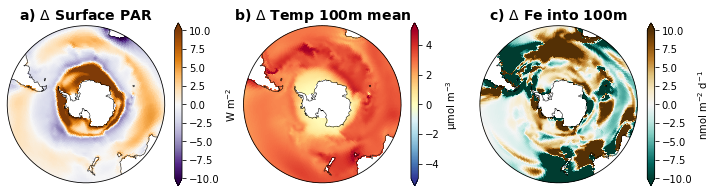

In [25]:
fig = plt.figure(figsize=(12,3))


#################################################################### plot SW map change
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Surface PAR', fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_2090s['PAR_surf'] - ensemble_mean_1920s['PAR_surf'])
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='W m$^{-2}$',size=10)
cbar1.ax.tick_params(labelsize=10)

################################################################### plot TEMP 100 change map
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Temp 100m mean',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TEMP_100m_mean- ensemble_mean_1920s.TEMP_100m_mean))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-5, vmax=5, 
                 cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='µmol m$^{-3}$',size=10)
cbar1.ax.tick_params(labelsize=10)


################################################################### plot Fe flux change map
ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ Fe into 100m',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phys_med_Fe- ensemble_mean_1920s.phys_med_Fe))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-10, vmax=10, 
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='nmol m$^{-2}$ d$^{-1}$',size=10)
cbar1.ax.tick_params(labelsize=10)

phytoplankton

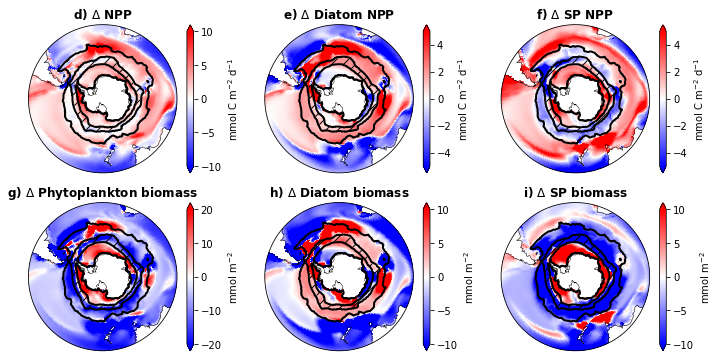

In [26]:
fig = plt.figure(figsize=(12,6))


################ NPP ################################################
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('d) ${\Delta}$ NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.NPP_zint100m- ensemble_mean_1920s.NPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol C m$^{-2}$ d$^{-1}$',size=10)

################ diat NPP ###############################################

ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('e) ${\Delta}$ Diatom NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatNPP_zint100m- ensemble_mean_1920s.diatNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol C m$^{-2}$ d$^{-1}$',size=10)

################ sp NPP ####################################################
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('f) ${\Delta}$ SP NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spNPP_zint100m- ensemble_mean_1920s.spNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol C m$^{-2}$ d$^{-1}$',size=10)




################ Biomass ################################################
ax = fig.add_subplot(2,3,4, projection=ccrs.SouthPolarStereo())
ax.set_title('g) ${\Delta}$ Phytoplankton biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phytoC_zint- ensemble_mean_1920s.phytoC_zint))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################# Diatom biomass #################################

ax = fig.add_subplot(2,3,5, projection=ccrs.SouthPolarStereo())
ax.set_title('h) ${\Delta}$ Diatom biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatC_zint100m- ensemble_mean_1920s.diatC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################################# SP biomass ###########################

ax = fig.add_subplot(2,3,6, projection=ccrs.SouthPolarStereo())
ax.set_title('i) ${\Delta}$ SP biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spC_zint100m- ensemble_mean_1920s.spC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')

cbar1.set_label(label='mmol m$^{-2}$',size=10)


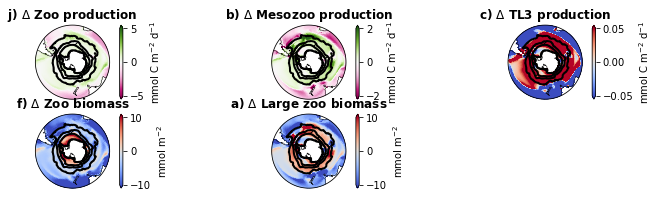

In [27]:
fig = plt.figure(figsize=(12,3))
cpt='PiYG'
################ zoo prod #########################################################
ax = fig.add_subplot(2,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('j) ${\Delta}$ Zoo production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zoo_prod_zint100m- ensemble_mean_1920s.zoo_prod_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol C m$^{-2}$ d$^{-1}$',size=10)

################ large zooplankton production #################################

ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Mesozoo production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC_prod- ensemble_mean_1920s.mesozooC_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-2, vmax=2, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol C m$^{-2}$ d$^{-1}$',size=10)

########################### TL 3 production #########################
cpt='coolwarm'
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ TL3 production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TL3_prod- ensemble_mean_1920s.TL3_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.05, vmax=0.05, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL3 production')
cbar1.set_label(label='mmol C m$^{-2}$ d$^{-1}$',size=10)



##################################### zoo biomass ############################
ax = fig.add_subplot(2,3,4, projection=ccrs.SouthPolarStereo())
ax.set_title('f) ${\Delta}$ Zoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zooC_zint100m- ensemble_mean_1920s.zooC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Zoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################# large zoo biomass ##################################
ax = fig.add_subplot(2,3,5, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Large zoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC- ensemble_mean_1920s.mesozooC))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Large zoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10)



### Put it all together

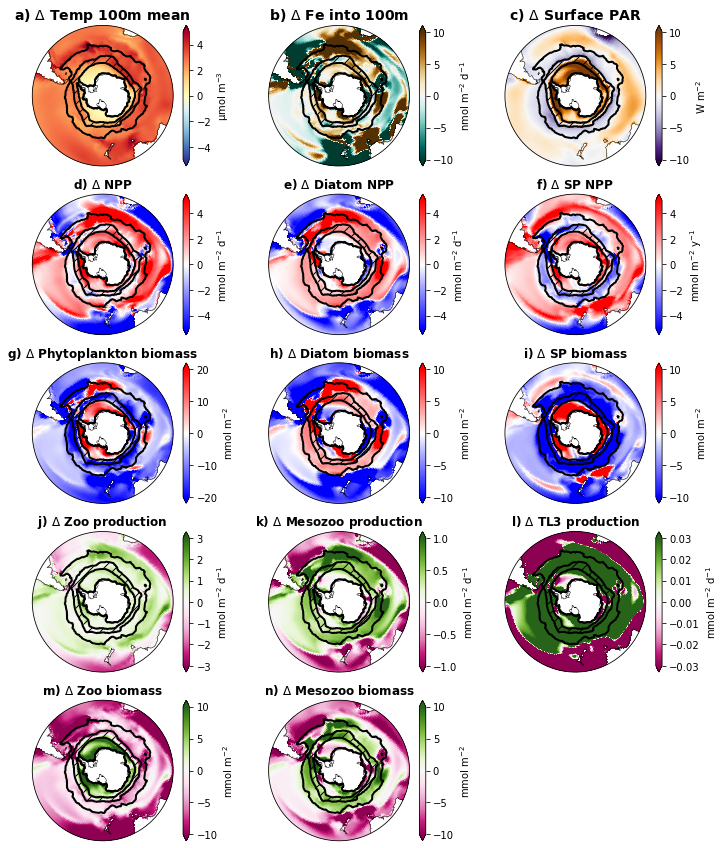

In [28]:
fig = plt.figure(figsize=(12,15))


################################################################### plot TEMP 100 change map
ax = fig.add_subplot(5,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Temp 100m mean',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TEMP_100m_mean- ensemble_mean_1920s.TEMP_100m_mean))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-5, vmax=5, 
                 cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='µmol m$^{-3}$',size=10)
cbar1.ax.tick_params(labelsize=10)


################################################################### plot Fe flux change map
ax = fig.add_subplot(5,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Fe into 100m',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phys_med_Fe- ensemble_mean_1920s.phys_med_Fe))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-10, vmax=10, 
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='nmol m$^{-2}$ d$^{-1}$',size=10)
cbar1.ax.tick_params(labelsize=10)



################################################################### plot light change map
ax = fig.add_subplot(5,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ Surface PAR', fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_2090s['PAR_surf'] - ensemble_mean_1920s['PAR_surf'])
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='W m$^{-2}$',size=10)
cbar1.ax.tick_params(labelsize=10)
####################################################################
# PHYTOPLANKTON
####################################################################



################ NPP ################################################
ax = fig.add_subplot(5,3,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) ${\Delta}$ NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.NPP_zint100m- ensemble_mean_1920s.NPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)

################ diat NPP ###############################################

ax = fig.add_subplot(5,3,5, projection=ccrs.SouthPolarStereo())
ax.set_title('e) ${\Delta}$ Diatom NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatNPP_zint100m- ensemble_mean_1920s.diatNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)

################ sp NPP ####################################################
ax = fig.add_subplot(5,3,6, projection=ccrs.SouthPolarStereo())
ax.set_title('f) ${\Delta}$ SP NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spNPP_zint100m- ensemble_mean_1920s.spNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ y$^{-1}$',size=10)




################ Biomass ################################################
ax = fig.add_subplot(5,3,7, projection=ccrs.SouthPolarStereo())
ax.set_title('g) ${\Delta}$ Phytoplankton biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phytoC_zint- ensemble_mean_1920s.phytoC_zint))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################# Diatom biomass #################################

ax = fig.add_subplot(5,3,8, projection=ccrs.SouthPolarStereo())
ax.set_title('h) ${\Delta}$ Diatom biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatC_zint100m- ensemble_mean_1920s.diatC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################################# SP biomass ###########################

ax = fig.add_subplot(5,3,9, projection=ccrs.SouthPolarStereo())
ax.set_title('i) ${\Delta}$ SP biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spC_zint100m- ensemble_mean_1920s.spC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')

cbar1.set_label(label='mmol m$^{-2}$',size=10)



####################################################################
# zoo & TL3
####################################################################


cpt='PiYG'
################ zoo prod #########################################################
ax = fig.add_subplot(5,3,10, projection=ccrs.SouthPolarStereo())
ax.set_title('j) ${\Delta}$ Zoo production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zoo_prod_zint100m- ensemble_mean_1920s.zoo_prod_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-3, vmax=3, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)

################ large zooplankton production #################################

ax = fig.add_subplot(5,3,11, projection=ccrs.SouthPolarStereo())
ax.set_title('k) ${\Delta}$ Mesozoo production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC_prod- ensemble_mean_1920s.mesozooC_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-1, vmax=1, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)

########################### TL 3 production #########################

ax = fig.add_subplot(5,3,12, projection=ccrs.SouthPolarStereo())
ax.set_title('l) ${\Delta}$ TL3 production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TL3_prod- ensemble_mean_1920s.TL3_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.03, vmax=0.03, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL3 production')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)



##################################### zoo biomass ############################
ax = fig.add_subplot(5,3,13, projection=ccrs.SouthPolarStereo())
ax.set_title('m) ${\Delta}$ Zoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zooC_zint100m- ensemble_mean_1920s.zooC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Zoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################# large zoo biomass ##################################
ax = fig.add_subplot(5,3,14, projection=ccrs.SouthPolarStereo())
ax.set_title('n) ${\Delta}$ Mesozoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC- ensemble_mean_1920s.mesozooC))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Mesozoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10)

fig.savefig('/glade/work/kristenk/figs/fig1_allmaps.png', bbox_inches='tight', dpi=300, format='png');

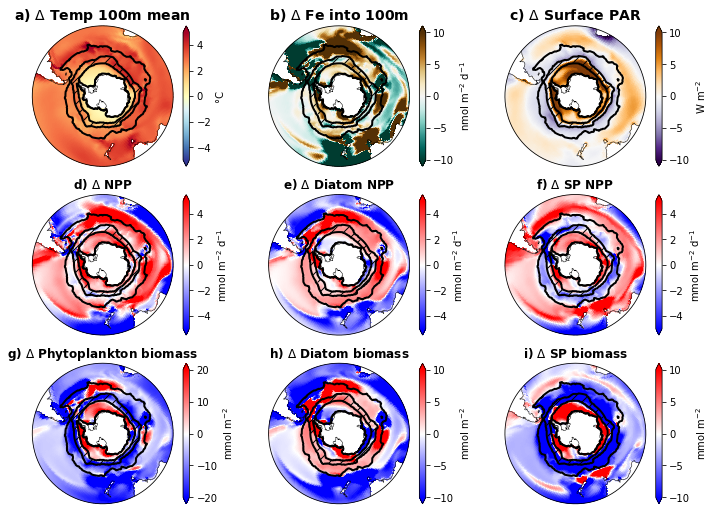

In [29]:
fig = plt.figure(figsize=(12,15))


################################################################### plot TEMP 100 change map
ax = fig.add_subplot(5,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Temp 100m mean',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TEMP_100m_mean- ensemble_mean_1920s.TEMP_100m_mean))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-5, vmax=5, 
                 cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='°C',size=10)
cbar1.ax.tick_params(labelsize=10)


################################################################### plot Fe flux change map
ax = fig.add_subplot(5,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Fe into 100m',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phys_med_Fe- ensemble_mean_1920s.phys_med_Fe))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-10, vmax=10, 
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='nmol m$^{-2}$ d$^{-1}$',size=10)
cbar1.ax.tick_params(labelsize=10)



################################################################### plot light change map
ax = fig.add_subplot(5,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ Surface PAR', fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_2090s['PAR_surf'] - ensemble_mean_1920s['PAR_surf'])
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='W m$^{-2}$',size=10)
cbar1.ax.tick_params(labelsize=10)
####################################################################
# PHYTOPLANKTON
####################################################################



################ NPP ################################################
ax = fig.add_subplot(5,3,4, projection=ccrs.SouthPolarStereo())
ax.set_title('d) ${\Delta}$ NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.NPP_zint100m- ensemble_mean_1920s.NPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)

################ diat NPP ###############################################

ax = fig.add_subplot(5,3,5, projection=ccrs.SouthPolarStereo())
ax.set_title('e) ${\Delta}$ Diatom NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatNPP_zint100m- ensemble_mean_1920s.diatNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)

################ sp NPP ####################################################
ax = fig.add_subplot(5,3,6, projection=ccrs.SouthPolarStereo())
ax.set_title('f) ${\Delta}$ SP NPP',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spNPP_zint100m- ensemble_mean_1920s.spNPP_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-5, vmax=5, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10)




################ Biomass ################################################
ax = fig.add_subplot(5,3,7, projection=ccrs.SouthPolarStereo())
ax.set_title('g) ${\Delta}$ Phytoplankton biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.phytoC_zint- ensemble_mean_1920s.phytoC_zint))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################# Diatom biomass #################################

ax = fig.add_subplot(5,3,8, projection=ccrs.SouthPolarStereo())
ax.set_title('h) ${\Delta}$ Diatom biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

#### plot diat frac
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diatC_zint100m- ensemble_mean_1920s.diatC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='mmol m$^{-2}$',size=10)


############################################# SP biomass ###########################

ax = fig.add_subplot(5,3,9, projection=ccrs.SouthPolarStereo())
ax.set_title('i) ${\Delta}$ SP biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.spC_zint100m- ensemble_mean_1920s.spC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both')

cbar1.set_label(label='mmol m$^{-2}$',size=10)


fig.savefig('/glade/work/kristenk/figs/fig1_allmaps_v2.png', bbox_inches='tight', dpi=300, format='png');

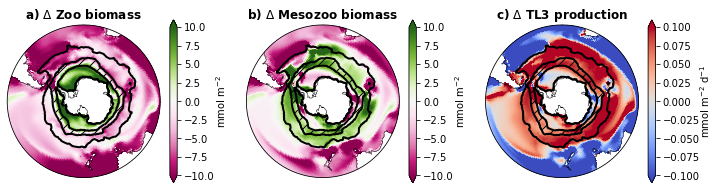

In [30]:
fig = plt.figure(figsize=(12,3))
####################################################################
# zoo biomass fields & TL3
####################################################################



##################################### zoo biomass ############################
ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) ${\Delta}$ Zoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.zooC_zint100m- ensemble_mean_1920s.zooC_zint100m))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Zoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10, labelpad=-1)


############################# large zoo biomass ##################################
ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ Mesozoo biomass',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.mesozooC- ensemble_mean_1920s.mesozooC))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-10, vmax=10, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ Mesozoo biomass')
cbar1.set_label(label='mmol m$^{-2}$',size=10, labelpad=-1)


########################### TL 3 production #########################
cpt='coolwarm'
ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_title('c) ${\Delta}$ TL3 production',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TL3_prod- ensemble_mean_1920s.TL3_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ TL3 production')
cbar1.set_label(label='mmol m$^{-2}$ d$^{-1}$',size=10, labelpad=-1)


fig.subplots_adjust(wspace=0.25)
fig.savefig('/glade/work/kristenk/figs/fig_zoomaps.png', bbox_inches='tight', dpi=300, format='png');

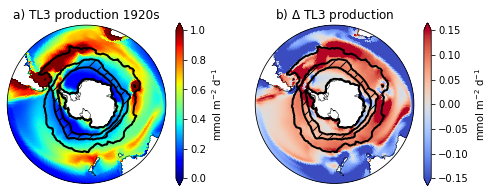

In [67]:
fig = plt.figure(figsize=(8,3))
####################################################################
# zoo biomass fields & TL3
####################################################################



##################################### 1920s TL3 prod ############################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('a) TL3 production 1920s' ,fontsize=12)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_2090s.TL3_prod)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$ d$^{-1}$' )



########################### TL 3 production #########################
cpt='coolwarm'
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) ${\Delta}$ TL3 production',fontsize=12)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.TL3_prod- ensemble_mean_1920s.TL3_prod))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.15, vmax=0.15, 
                 cmap='coolwarm',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$ d$^{-1}$')


fig.subplots_adjust(wspace=0.25)
fig.savefig('/glade/work/kristenk/figs/TL3_prod_fig.png', bbox_inches='tight', dpi=300, format='png');

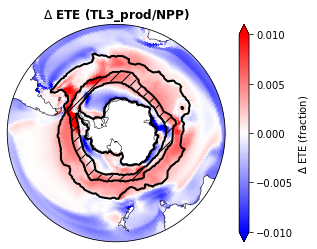

In [68]:
fig = plt.figure(figsize=(5,4))
####################################################################
# ETE
####################################################################

cpt='bwr'

##################################### zoo biomass ############################
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ ETE (TL3_prod/NPP)',fontsize=12, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.ETE_to_TL3- ensemble_mean_1920s.ETE_to_TL3))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.01, vmax=0.01, 
                 cmap=cpt,
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)


pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ ETE (fraction)')
#cbar1.set_label(label='mmol m$^{-2}$',size=10, labelpad=-1)
cbar1.set_ticks([-0.01,-0.005,0,0.005,0.01])  # horizontal colorbar